**9. Analysing Offensive Value added by left and right footed players in different regions**<br>
We have tried to understand how different players fare on accuracy (number of accurate progressive passes in a particular region / total progressive passes in that region) vs preference (number of progressive passes in a region/ total progressive passes made). We have further analysed the offensive value that each player adds in different region for accurate progressive passes, inaccurate progressive passes and total progressive passes.

The following tasks have been taken into account in this notebook:

1. Extract progressive passes and VAEP, offensive and defensive values and filter them bases on the regions

2. Compute accuracy and preference for progressive passes in each region for a particular player and plot it for every region

3. Compute offensive value added per accurate progressive pass and plot it with preference of making an accurate progressive pass in each region. Perform the same activity for inaccurate passes as well

4. Compute offensive value added per progressive pass (accurate and inaccurate) and plot it with preference of making a progressive pass in each region

The following results have been saved:

1. Plots for preference vs accuracy

2. Plots for accurate progressive pass preference vs offensive value added per accurate progressive pass

3. Plots for inaccurate progressive pass preference vs offensive value added per inaccurate progressive pass

4. Plots for progressive pass preference vs offensive value added per progressive pass


Note: The column names for the dataframe used for plotting have been explained in the `Appendix` section



# Imports 

In [122]:
import numpy as np
import pandas as pd
import pickle
import plotly.graph_objects as go
import statistics
pd.set_option('max_columns',1000)

# Data 

In [125]:
# Reading defender wise passing attributes dataset
defender_attrs = pd.read_pickle('../data/defender_clusters/defender_clustering_dataset.pkl')

In [126]:
# Filtering out left center backs from this dataset for both 4 at the back and non 4 at the back formations
defender_attrs_lcb = defender_attrs.loc[(defender_attrs['position']=='LCB') | (defender_attrs['position']=='L_CB')]

In [127]:
defender_attrs_lcb.head()

,player_name,team,position,footedness,passes,accpass,accpassloc,inaccpassloc,accpassvaep,inaccpassvaep,accpassoff,inaccpassoff,accpassdef,inaccpassdef,matches_played
1,AaronCresswell,West Ham,LCB,left,796,644,"[[[27.04, 51.68], [55.12, 64.6]], [[65.52, 61....","[[[62.4, 51.0], [78.0, 49.64]], [[79.04, 61.2]...","[0.0010694738011807203, 0.002371369395405054, ...","[-0.00956201646476984, -0.007710381411015987, ...","[0.0018120664171874523, 0.002711281180381775, ...","[-0.006647953763604164, -0.006097717210650444,...","[-0.0007425926742143929, -0.000339911784976720...","[-0.002914062701165676, -0.001612664433196187,...",20.0
7,AdrianMariappa,Watford,L_CB,right,179,144,"[[[36.4, 45.56], [74.88, 48.28]], [[30.16, 46....","[[[43.68, 20.4], [42.64, 26.52]], [[27.04, 59....","[0.007817169651389122, 0.014505142346024513, -...","[-0.012487044557929039, -0.014621571637690067,...","[0.006556161679327488, 0.014376532286405563, -...","[0.0002851502504199743, 0.0005775007884949446,...","[0.0012610082048922777, 0.0001286100596189499,...","[-0.012772195041179657, -0.015199072659015656,...",5.0
12,AhmedHegazi,West Brom,LCB,right,108,85,"[[[30.16, 59.84], [8.32, 52.36]], [[13.52, 45....","[[[38.48, 63.24], [67.6, 62.56]], [[32.24, 57....","[-0.0006447772029787302, 0.005508015863597393,...","[-0.0023842889349907637, -0.000174969201907515...","[-0.0004856684245169163, 0.0003083648625761270...","[-0.0002966243773698807, 0.0005698907189071178...","[-0.00015910877846181393, 0.00519965123385191,...","[-0.002087664557620883, -0.0007448599208146334...",3.0
13,AhmedHegazi,West Brom,L_CB,right,438,347,"[[[31.2, 44.88], [41.6, 44.2]], [[46.8, 48.96]...","[[[41.6, 57.12], [70.72, 56.44]], [[27.04, 52....","[0.0017347207758575678, 0.0011076731607317924,...","[-0.003586119506508112, -0.0061787767335772514...","[0.0009571132250130177, 9.425170719623566e-05,...","[-0.0005135340616106987, -0.000820334302261471...","[0.0007776075508445501, 0.0010134214535355568,...","[-0.0030725854448974133, -0.005358442664146423...",16.0
21,AlfieMawson,Swansea,LCB,right,758,620,"[[[22.88, 47.6], [28.08, 57.12]], [[42.64, 63....","[[[6.24, 65.28], [3.12, 66.64]], [[28.08, 60.5...","[0.038905542343854904, -0.00048424117267131805...","[-0.0028287151362746954, -0.004615758545696735...","[0.0026092270854860544, 0.0003214506432414055,...","[-0.000753563828766346, -0.0015460746362805367...","[0.03629631549119949, -0.0008056918159127235, ...","[-0.0020751513075083494, -0.003069684142246842...",19.0


# Filtering for Progressive Values

In [128]:
# Function to get start and end location points for every row in df
def getstartend(locs):
    end_points = list()
    start_points = list()
    for point in locs:
            if point != []:
                end_points.append(point[1])
                start_points.append(point[0])
    return start_points,end_points

In [129]:
# Function to segregate progressive passes for every row of pass location column
def distfilter(locs,vaeps):
    loc_start, loc_end = getstartend(locs)
    progpass = 0
    prog_passlocs = list()
    prog_passvaeps = list()
    for p1,p2,vaep in zip(loc_start,loc_end,vaeps):
        dist = np.round(np.linalg.norm(np.array(p1) - np.array(p2)),2)
        if p1[0] < 52 and dist >= 30 and p1[0] < p2[0]:
            prog_passlocs.append([np.round(p1,2),np.round(p2,2)])
            prog_passvaeps.append(vaep)
        elif p1[0] > 52 and dist >= 10 and p1[0] < p2[0]:
            prog_passlocs.append([np.round(p1,2),np.round(p2,2)])
            prog_passvaeps.append(vaep)
    progpass = len(prog_passlocs)
    return pd.Series([prog_passlocs,prog_passvaeps,progpass])
            

In [130]:
defender_attrs_lcb[[
    'progaccpassloc', 'progaccpassvaep', 'progaccpass'
]] = defender_attrs_lcb.apply(
    lambda x: distfilter(x['accpassloc'], x['accpassvaep']), axis=1)

defender_attrs_lcb[[
    'proginaccpassloc', 'proginaccpassvaep', 'proginaccpass'
]] = defender_attrs_lcb.apply(
    lambda x: distfilter(x['inaccpassloc'], x['inaccpassvaep']), axis=1)

defender_attrs_lcb[[
    'progaccpassloc', 'progaccpassoff', 'progaccpass'
]] = defender_attrs_lcb.apply(
    lambda x: distfilter(x['accpassloc'], x['accpassoff']), axis=1)

defender_attrs_lcb[[
    'proginaccpassloc', 'proginaccpassoff', 'proginaccpass'
]] = defender_attrs_lcb.apply(
    lambda x: distfilter(x['inaccpassloc'], x['inaccpassoff']), axis=1)

defender_attrs_lcb[[
    'progaccpassloc', 'progaccpassdef', 'progaccpass'
]] = defender_attrs_lcb.apply(
    lambda x: distfilter(x['accpassloc'], x['accpassdef']), axis=1)

defender_attrs_lcb[[
    'proginaccpassloc', 'proginaccpassdef', 'proginaccpass'
]] = defender_attrs_lcb.apply(
    lambda x: distfilter(x['inaccpassloc'], x['inaccpassdef']), axis=1)

/Users/shreygrover/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [131]:
# Resetting the index
defender_attrs_lcb.reset_index(inplace = True)

In [132]:
# Dropping defenders who have zero progressive passes
defender_attrs_lcb = defender_attrs_lcb.loc[defender_attrs_lcb['progaccpass']!=0]

In [133]:
# Counting the total number of accurate progressive passes and accurate progressive vaep values for left center backs
counter_accprog = 0
counter_accprog_vaep = 0
counter_accprog_off = 0
counter_accprog_def = 0
for index, row in defender_attrs_lcb.iterrows():
    counter_accprog = counter_accprog + len(row['progaccpassloc'])
    counter_accprog_vaep = counter_accprog_vaep + len(row['progaccpassvaep'])
    counter_accprog_off = counter_accprog_off + len(row['progaccpassoff'])
    counter_accprog_def = counter_accprog_def + len(row['progaccpassdef'])    
    

In [134]:
# Counting the total number of inaccurate progressive passes and inaccurate progressive vaep values for left center backs
counter_inaccprog = 0
counter_inaccprog_vaep = 0
counter_inaccprog_off = 0
counter_inaccprog_def = 0
for index, row in defender_attrs_lcb.iterrows():
    counter_inaccprog = counter_inaccprog + len(row['proginaccpassloc'])
    counter_inaccprog_vaep = counter_inaccprog_vaep + len(row['proginaccpassvaep'])
    counter_inaccprog_off = counter_inaccprog_off + len(row['proginaccpassoff'])
    counter_inaccprog_def = counter_inaccprog_def + len(row['proginaccpassdef'])

In [135]:
counter_accprog, counter_accprog_vaep, counter_accprog_off, counter_accprog_def

(6864, 6864, 6864, 6864)

In [136]:
counter_inaccprog, counter_inaccprog_vaep, counter_inaccprog_off, counter_inaccprog_def

(2314, 2314, 2314, 2314)

In [137]:
np.sum(defender_attrs_lcb['progaccpass'].tolist())

6864

In [138]:
np.sum(defender_attrs_lcb['proginaccpass'].tolist())

2314

In [139]:
# Changing the order of the columns
new_def_cols = [
    'index', 'player_name', 'team', 'position', 'footedness', 'matches_played',
    'passes', 'accpass', 'progaccpass', 'proginaccpass', 'accpassloc',
    'inaccpassloc', 'progaccpassloc', 'proginaccpassloc', 'accpassvaep',
    'inaccpassvaep', 'progaccpassvaep', 'proginaccpassvaep', 'accpassoff',
    'inaccpassoff', 'progaccpassoff', 'proginaccpassoff', 'accpassdef',
    'inaccpassdef', 'progaccpassdef', 'proginaccpassdef'
]
print(len(new_def_cols))
defender_attrs_lcb = defender_attrs_lcb[new_def_cols]

26


In [140]:
defender_attrs_lcb.head()

,index,player_name,team,position,footedness,matches_played,passes,accpass,progaccpass,proginaccpass,accpassloc,inaccpassloc,progaccpassloc,proginaccpassloc,accpassvaep,inaccpassvaep,progaccpassvaep,proginaccpassvaep,accpassoff,inaccpassoff,progaccpassoff,proginaccpassoff,accpassdef,inaccpassdef,progaccpassdef,proginaccpassdef
0,1,AaronCresswell,West Ham,LCB,left,20.0,796,644,184,91,"[[[27.04, 51.68], [55.12, 64.6]], [[65.52, 61....","[[[62.4, 51.0], [78.0, 49.64]], [[79.04, 61.2]...","[[[27.04, 51.68], [55.12, 64.6]], [[61.36, 59....","[[[62.4, 51.0], [78.0, 49.64]], [[79.04, 61.2]...","[0.0010694738011807203, 0.002371369395405054, ...","[-0.00956201646476984, -0.007710381411015987, ...","[0.0010694738011807203, 0.002284318208694458, ...","[-0.00956201646476984, -0.007710381411015987, ...","[0.0018120664171874523, 0.002711281180381775, ...","[-0.006647953763604164, -0.006097717210650444,...","[0.0018120664171874523, 0.0021007489413022995,...","[-0.006647953763604164, -0.006097717210650444,...","[-0.0007425926742143929, -0.000339911784976720...","[-0.002914062701165676, -0.001612664433196187,...","[-0.0007425926742143929, 0.0001835691509768366...","[-0.002914062701165676, -0.001612664433196187,..."
1,7,AdrianMariappa,Watford,L_CB,right,5.0,179,144,29,17,"[[[36.4, 45.56], [74.88, 48.28]], [[30.16, 46....","[[[43.68, 20.4], [42.64, 26.52]], [[27.04, 59....","[[[36.4, 45.56], [74.88, 48.28]], [[30.16, 46....","[[[74.88, 48.28], [95.68, 63.92]], [[43.68, 58...","[0.007817169651389122, 0.014505142346024513, -...","[-0.012487044557929039, -0.014621571637690067,...","[0.007817169651389122, 0.014505142346024513, 0...","[-0.018855780363082886, -0.0001047381665557622...","[0.006556161679327488, 0.014376532286405563, -...","[0.0002851502504199743, 0.0005775007884949446,...","[0.006556161679327488, 0.014376532286405563, 0...","[-0.016433699056506157, -0.001886303536593914,...","[0.0012610082048922777, 0.0001286100596189499,...","[-0.012772195041179657, -0.015199072659015656,...","[0.0012610082048922777, 0.0001286100596189499,...","[-0.0024220815394073725, 0.0017815653700381517..."
2,12,AhmedHegazi,West Brom,LCB,right,3.0,108,85,25,14,"[[[30.16, 59.84], [8.32, 52.36]], [[13.52, 45....","[[[38.48, 63.24], [67.6, 62.56]], [[32.24, 57....","[[[9.36, 49.64], [46.8, 35.36]], [[59.28, 60.5...","[[[32.24, 57.8], [94.64, 8.84]], [[37.44, 55.7...","[-0.0006447772029787302, 0.005508015863597393,...","[-0.0023842889349907637, -0.000174969201907515...","[0.005519402213394642, 0.014088563621044159, 0...","[-0.00017496920190751553, -0.00290540279820561...","[-0.0004856684245169163, 0.0003083648625761270...","[-0.0002966243773698807, 0.0005698907189071178...","[0.004861586727201939, 0.014564938843250275, 0...","[0.0005698907189071178, 0.0005573607049882412,...","[-0.00015910877846181393, 0.00519965123385191,...","[-0.002087664557620883, -0.0007448599208146334...","[0.0006578152533620596, -0.0004763756878674030...","[-0.0007448599208146334, -0.003462763503193855..."
3,13,AhmedHegazi,West Brom,L_CB,right,16.0,438,347,72,46,"[[[31.2, 44.88], [41.6, 44.2]], [[46.8, 48.96]...","[[[41.6, 57.12], [70.72, 56.44]], [[27.04, 52....","[[[35.36, 38.08], [43.68, 5.44]], [[33.28, 38....","[[[30.16, 6.12], [69.68, 20.4]], [[87.36, 60.5...","[0.0017347207758575678, 0.0011076731607317924,...","[-0.003586119506508112, -0.0061787767335772514...","[0.001253026886843145, 0.007582114078104496, 0...","[0.0008075747173279524, -0.011176194064319134,...","[0.0009571132250130177, 9.425170719623566e-05,...","[-0.0005135340616106987, -0.000820334302261471...","[0.001169776078313589, 0.007204808760434389, 0...","[0.0003615876194089651, -0.01037642266601324, ...","[0.0007776075508445501, 0.0010134214535355568,...","[-0.0030725854448974133, -0.005358442664146423...","[8.32508085295558e-05, 0.00037730508483946323,...","[0.0004459870979189873, -0.0007997713983058929..."
4,21,AlfieMawson,Swansea,LCB,right,19.0,758,620,150,74,"[[[22.88, 47.6], [28.08, 57.12]], [[42.64, 63....","[[[6.24, 65.

In [141]:
# Saving dataframe in data folder
defender_attrs_lcb.to_pickle('../data/defender_clusters/defender_attrs_lcb_prog.pkl')

# Extracting Regions of Progressive Values 

In [142]:
defender_attrs_lcb = pd.read_pickle('../data/defender_clusters/defender_attrs_lcb_prog.pkl')

In [143]:
# Function to get x and y coordinates of pass locations
def getxy(locs):
    x = list()
    y = list()
    for p in locs:
        x.append(p[0])
        y.append(p[1])
    return x,y

In [144]:
# Function to calcuate total value added by passes in each of the following regions:
#  ( x - length of the pitch) (y - width of the pitch)
# Right Flank Attack - x >= 52 and y <= 17
# Right Flank Defence - x < 52 and y <= 17
# Right Central Attack - x >= 52 and y > 17 and y <= 34
# Right Central Defence - x < 52 and y > 17 and y <= 34
# Left Central Attack - x >= 52 and y > 34 and y <= 51
# Left Central Defence - x < 52 and y > 34 and y <= 51
# Left Flank Attack - x >= 52 and y > 51 and y <= 68
# Left Flank Defence - x < 52 and y > 51 and y <= 68
def get_vaep_region(x, y, vaep):
    vaep_rightflank_attack, vaep_rightflank_defence, vaep_rightcentral_attack, vaep_rightcentral_defence, vaep_leftcentral_attack, vaep_leftcentral_defence, vaep_leftflank_attack, vaep_leftflank_defence = 0, 0, 0, 0, 0, 0, 0, 0
    if vaep != []:
        vaep_rightflank_attack = np.sum(
            [vaep[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] <= 17)])
        vaep_rightflank_defence = np.sum(
            [vaep[i] for i in range(len(x)) if (x[i] < 52) and (y[i] <= 17)])
        vaep_rightcentral_attack = np.sum([
            vaep[i] for i in range(len(x))
            if (x[i] >= 52) and (y[i] > 17) and (y[i] <= 34)
        ])
        vaep_rightcentral_defence = np.sum([
            vaep[i] for i in range(len(x))
            if (x[i] < 52) and (y[i] > 17) and (y[i] <= 34)
        ])
        vaep_leftcentral_attack = np.sum([
            vaep[i] for i in range(len(x))
            if (x[i] >= 52) and (y[i] > 34) and (y[i] <= 51)
        ])
        vaep_leftcentral_defence = np.sum([
            vaep[i] for i in range(len(x))
            if (x[i] < 52) and (y[i] > 34) and (y[i] <= 51)
        ])
        vaep_leftflank_attack = np.sum([
            vaep[i] for i in range(len(x))
            if (x[i] >= 52) and (y[i] > 51) and (y[i] <= 68)
        ])
        vaep_leftflank_defence = np.sum([
            vaep[i] for i in range(len(x))
            if (x[i] < 52) and (y[i] > 51) and (y[i] <= 68)
        ])

    return [
        vaep_leftflank_defence, vaep_leftcentral_defence,
        vaep_rightcentral_defence, vaep_rightflank_defence,
        vaep_leftflank_attack, vaep_leftcentral_attack,
        vaep_rightcentral_attack, vaep_rightflank_attack
    ]

In [145]:
# Function to get total number of progressive pass made in each of the following regions:
#  ( x - length of the pitch) (y - width of the pitch)
# Right Flank Attack - x >= 52 and y <= 17
# Right Flank Defence - x < 52 and y <= 17
# Right Central Attack - x >= 52 and y > 17 and y <= 34
# Right Central Defence - x < 52 and y > 17 and y <= 34
# Left Central Attack - x >= 52 and y > 34 and y <= 51
# Left Central Defence - x < 52 and y > 34 and y <= 51
# Left Flank Attack - x >= 52 and y > 51 and y <= 68
# Left Flank Defence - x < 52 and y > 51 and y <= 68
def get_pass_region(x,y):
    x_rightflank_attack, x_rightflank_def, x_leftflank_attack, x_leftflank_def, x_rightcentral_attack, x_rightcentral_def, x_leftcentral_attack, x_leftcentral_def = list(),list(),list(),list(),list(),list(),list(),list()
    if x!=[]:
        x_rightflank_attack = [
            x[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] <= 17)]
        y_rightflank_attack = [
            y[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] <= 17)]
        x_rightflank_def = [
            x[i] for i in range(len(x)) if (x[i] < 52) and (y[i] <= 17)]
        y_rightflank_def = [
            y[i] for i in range(len(x)) if (x[i] < 52) and (y[i] <= 17)]
        x_leftflank_attack = [
            x[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] > 51)]
        y_leftflank_attack = [
            y[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] > 51)]
        x_leftflank_def = [
            x[i] for i in range(len(x)) if (x[i] < 52) and (y[i] > 51)]
        y_leftflank_def = [
            y[i] for i in range(len(x)) if (x[i] < 52) and (y[i] > 51)]
        x_rightcentral_attack = [
            x[i] for i in range(len(x))
            if (x[i] >= 52) and (y[i] > 17) and (y[i] <= 34)]
        y_rightcentral_attack = [
            y[i] for i in range(len(x))
            if (x[i] >= 52) and (y[i] > 17) and (y[i] <= 34)]
        x_rightcentral_def = [
            x[i] for i in range(len(x))
            if (x[i] < 52) and (y[i] > 17) and (y[i] <= 34)]
        y_rightcentral_def = [
            y[i] for i in range(len(x))
            if (x[i] < 52) and (y[i] > 17) and (y[i] <= 34)]
        x_leftcentral_attack = [
            x[i] for i in range(len(x))
            if (x[i] >= 52) and (y[i] > 34) and (y[i] <= 51)]
        y_leftcentral_attack = [
            y[i] for i in range(len(x))
            if (x[i] >= 52) and (y[i] > 34) and (y[i] <= 51)]
        x_leftcentral_def = [
            x[i] for i in range(len(x))
            if (x[i] < 52) and (y[i] > 34) and (y[i] <= 51)]
        y_leftcentral_def = [
            y[i] for i in range(len(x))
            if (x[i] < 52) and (y[i] > 34) and (y[i] <= 51)]
    return [len(x_leftflank_def), len(x_leftcentral_def),
        len(x_rightcentral_def), len(x_rightflank_def), 
        len(x_leftflank_attack), len(x_leftcentral_attack), 
        len(x_rightcentral_attack), len(x_rightflank_attack)]

In [146]:
# Function to calculate progressive passes per region and vaep value per region
# Note: vaep value is divided by the number of progresssive passes and scaled to 1000 to make the value significant for visualisation
def get_region_wise(locs, vaep):
    locs_start, locs_end = getstartend(locs)
    locs_x, locs_y = getxy(locs_end)
    vaep_region = get_vaep_region(locs_x, locs_y, vaep)
    prog_region = get_pass_region(locs_x, locs_y)
    vaep_region_per_pass = list()
    prog_region_per_pass = list()
    if prog_region != []:
        for i, j in zip(vaep_region, prog_region):
            if j == 0:
                vaep_region_per_pass.append(0)
                prog_region_per_pass.append(j)
            else:
                vaep_region_per_pass.append((i / j) * 1000)
                prog_region_per_pass.append(np.round(j / len(locs_x) * 100, 2))
    else:
        vaep_region_per_pass = list()
        prog_region_per_pass = list()
    return pd.Series([prog_region_per_pass, vaep_region_per_pass])

In [147]:
defender_attrs_lcb[[
    'prog_acc_region_per_pass', 'vaep_acc_region_per_pass'
]] = defender_attrs_lcb.apply(
    lambda x: get_region_wise(x['progaccpassloc'], x['progaccpassvaep']),
    axis=1)

defender_attrs_lcb[[
    'prog_inacc_region_per_pass', 'vaep_inacc_region_per_pass'
]] = defender_attrs_lcb.apply(
    lambda x: get_region_wise(x['proginaccpassloc'], x['proginaccpassvaep']),
    axis=1)

defender_attrs_lcb[[
    'prog_acc_region_per_pass', 'off_acc_region_per_pass'
]] = defender_attrs_lcb.apply(
    lambda x: get_region_wise(x['progaccpassloc'], x['progaccpassoff']),
    axis=1)

defender_attrs_lcb[[
    'prog_inacc_region_per_pass', 'off_inacc_region_per_pass'
]] = defender_attrs_lcb.apply(
    lambda x: get_region_wise(x['proginaccpassloc'], x['proginaccpassoff']),
    axis=1)

defender_attrs_lcb[[
    'prog_acc_region_per_pass', 'def_acc_region_per_pass'
]] = defender_attrs_lcb.apply(
    lambda x: get_region_wise(x['progaccpassloc'], x['progaccpassdef']),
    axis=1)

defender_attrs_lcb[[
    'prog_inacc_region_per_pass', 'def_inacc_region_per_pass'
]] = defender_attrs_lcb.apply(
    lambda x: get_region_wise(x['proginaccpassloc'], x['proginaccpassdef']),
    axis=1)

In [148]:
defender_attrs_lcb.head()

,index,player_name,team,position,footedness,matches_played,passes,accpass,progaccpass,proginaccpass,accpassloc,inaccpassloc,progaccpassloc,proginaccpassloc,accpassvaep,inaccpassvaep,progaccpassvaep,proginaccpassvaep,accpassoff,inaccpassoff,progaccpassoff,proginaccpassoff,accpassdef,inaccpassdef,progaccpassdef,proginaccpassdef,prog_acc_region_per_pass,vaep_acc_region_per_pass,prog_inacc_region_per_pass,vaep_inacc_region_per_pass,off_acc_region_per_pass,off_inacc_region_per_pass,def_acc_region_per_pass,def_inacc_region_per_pass
0,1,AaronCresswell,West Ham,LCB,left,20.0,796,644,184,91,"[[[27.04, 51.68], [55.12, 64.6]], [[65.52, 61....","[[[62.4, 51.0], [78.0, 49.64]], [[79.04, 61.2]...","[[[27.04, 51.68], [55.12, 64.6]], [[61.36, 59....","[[[62.4, 51.0], [78.0, 49.64]], [[79.04, 61.2]...","[0.0010694738011807203, 0.002371369395405054, ...","[-0.00956201646476984, -0.007710381411015987, ...","[0.0010694738011807203, 0.002284318208694458, ...","[-0.00956201646476984, -0.007710381411015987, ...","[0.0018120664171874523, 0.002711281180381775, ...","[-0.006647953763604164, -0.006097717210650444,...","[0.0018120664171874523, 0.0021007489413022995,...","[-0.006647953763604164, -0.006097717210650444,...","[-0.0007425926742143929, -0.000339911784976720...","[-0.002914062701165676, -0.001612664433196187,...","[-0.0007425926742143929, 0.0001835691509768366...","[-0.002914062701165676, -0.001612664433196187,...","[1.63, 0, 0.54, 0, 66.3, 19.57, 8.15, 3.8]","[16.502801328897476, 0, 3.1730758491903543, 0,...","[2.2, 3.3, 0, 2.2, 37.36, 36.26, 10.99, 7.69]","[-0.38534030318260193, 1.5773851579676073, 0, ...","[2.848291303962469, 0, 1.703751739114523, 0, 5...","[-0.1581189571879804, -0.8412844811876615, 0, ...","[13.65451041298608, 0, 1.4693241100758314, 0, ...","[-0.22722140420228243, 2.418669561545054, 0, 0..."
1,7,AdrianMariappa,Watford,L_CB,right,5.0,179,144,29,17,"[[[36.4, 45.56], [74.88, 48.28]], [[30.16, 46....","[[[43.68, 20.4], [42.64, 26.52]], [[27.04, 59....","[[[36.4, 45.56], [74.88, 48.28]], [[30.16, 46....","[[[74.88, 48.28], [95.68, 63.92]], [[43.68, 58...","[0.007817169651389122, 0.014505142346024513, -...","[-0.012487044557929039, -0.014621571637690067,...","[0.007817169651389122, 0.014505142346024513, 0...","[-0.018855780363082886, -0.0001047381665557622...","[0.006556161679327488, 0.014376532286405563, -...","[0.0002851502504199743, 0.0005775007884949446,...","[0.006556161679327488, 0.014376532286405563, 0...","[-0.016433699056506157, -0.001886303536593914,...","[0.0012610082048922777, 0.0001286100596189499,...","[-0.012772195041179657, -0.015199072659015656,...","[0.0012610082048922777, 0.0001286100596189499,...","[-0.0024220815394073725, 0.0017815653700381517...","[6.9, 0, 0, 3.45, 44.83, 17.24, 17.24, 10.34]","[9.83715383335948, 0, 0, 0.6926651112735271, 5...","[0, 0, 0, 0, 41.18, 35.29, 11.76, 11.76]","[0, 0, 0, 0, -5.499570198091013, 1.03639046816...","[3.170753479935229, 0, 0, 0.3402489237487316, ...","[0, 0, 0, 0, -5.058952174814684, -0.6287569801...","[6.666399887762964, 0, 0, 0.35241618752479553,...","[0, 0, 0, 0, -0.4406179900148085, 1.6651475258..."
2,12,AhmedHegazi,West Brom,LCB,right,3.0,108,85,25,14,"[[[30.16, 59.84], [8.32, 52.36]], [[13.52, 45....","[[[38.48, 63.24], [67.6, 62.56]], [[32.24, 57....","[[[9.36, 49.64], [46.8, 35.36]], [[59.28, 60.5...","[[[32.24, 57.8], [94.64, 8.84]], [[37.44, 55.7...","[-0.0006447772029787302, 0.005508015863597393,...","[-0.0023842889349907637, -0.000174969201907515...","[0.005519402213394642, 0.014088563621044159, 0...","[-0.00017496920190751553, -0.00290540279820561...","[-0.0004856684245169163, 0.0003083648625761270...","[-0.0002966243773698807, 0.0005698907189071178...","[0.004861586727201939, 0.014564938843250275, 0...","[0.0005698907189071178, 0.0005573607049882412,...","[-0.00015910877846181393, 0.00519965123385191,...","[-0.002087664557620883, -0.0007448599208146334...","[0.0006578152533620596, -0.0004763756878674030...","[-0.0007448599208146334, -0.003462763503193855..

# Generating Accuracy vs Preference Plots 

In [149]:
# Function to get preference (i.e. what percentage of progressive passes does the player make in each region) and
# accuracy (i.e. what is the accuracy of making progressive passes in each region)
def get_preference_accuracy(progaccpassloc, proginaccpassloc):
    progpasses = list(progaccpassloc) + list(proginaccpassloc)
    progpasses_start, progpasses_end = getstartend(progpasses)
    progaccpass_start, progaccpass_end = getstartend(progaccpassloc)
    #     proginaccpass_start, proginaccpass_end = getstartend(proginaccpassloc)
    prog_locs_x, prog_locs_y = getxy(progpasses_end)
    progaccpass_locs_x, progaccpass_locs_y = getxy(progaccpass_end)
    #     proginaccpass_locs_x, proginaccpass_locs_y = getxy(proginaccpass_end)
    prog_region = get_pass_region(prog_locs_x, prog_locs_y)
    progacc_pass_region = get_pass_region(progaccpass_locs_x,
                                          progaccpass_locs_y)
    proginacc_pass_region = [
        prog_region[i] - progacc_pass_region[i] for i in range(8)
    ]
    progpreference_per_region = list()
    progaccuracy_per_region = list()
    if prog_region != []:
        for i in range(8):
            if prog_region[i] != 0:
                progpreference_per_region.append(
                    np.round((prog_region[i] / len(prog_locs_x)) * 100, 2))
                progaccuracy_per_region.append(
                    np.round((progacc_pass_region[i] / prog_region[i]) * 100,
                             2))
            else:
                progpreference_per_region.append(
                    np.round((prog_region[i] / len(prog_locs_x)) * 100, 2))
                progaccuracy_per_region.append(0)
    else:
        progpreference_per_region = list()
        progaccuracy_per_region = list()
    return pd.Series([progpreference_per_region, progaccuracy_per_region])

In [150]:
defender_attrs_lcb[['progpreference_per_region',
                    'progaccuracy_per_region']] = defender_attrs_lcb.apply(
                        lambda x: get_preference_accuracy(
                            x['progaccpassloc'], x['proginaccpassloc']),
                        axis=1)

In [178]:
# Considering only those Players who have made more than 20 Progressive Passes throughout the Season 
defender_attrs_lcb_plot_prefacc = defender_attrs_lcb.loc[(
    defender_attrs_lcb['progaccpass'] +
    defender_attrs_lcb['proginaccpass']) >= 20]

In [209]:
# Function to plot preference vs accuracy for progressive passes in each region
def plot_preference_accuracy_region(df):
    regions = [
        'leftflank_def', 'leftcentral_def', 'rightcentral_def',
        'rightflank_def', 'leftflank_attack', 'leftcentral_attack',
        'rightcentral_attack', 'rightflank_attack'
    ]
    foot2color = {'left': 'rgb(60,48,39)', 'right': 'rgb(215,148,39)'}
    foot_colors = df['footedness'].map(foot2color)
    for i in range(8):
        prog_region_right,prog_region_left = list(), list()
        acc_region_right,acc_region_left = list(), list()
        player_name_right,player_name_left = list(), list()
        player_position_right,player_position_left = list(), list()
        player_foot_right,player_foot_left = list(), list()
        player_team_right,player_team_left = list(), list()
        df_right = df.loc[df['footedness']=='right']
        df_left = df.loc[df['footedness']=='left']
        for idx, row in df_right.iterrows():
            prog_region_right.append(row['progpreference_per_region'][i])
            acc_region_right.append(row['progaccuracy_per_region'][i])
            player_name_right.append(row['player_name'])
            player_position_right.append(row['position'])
            player_team_right.append(row['team'])
        for idx, row in df_left.iterrows():
            prog_region_left.append(row['progpreference_per_region'][i])
            acc_region_left.append(row['progaccuracy_per_region'][i])
            player_name_left.append(row['player_name'])
            player_position_left.append(row['position'])
            player_team_left.append(row['team'])
        prog_region = prog_region_right + prog_region_left
        acc_region = acc_region_right + acc_region_left
        fig = go.Figure()
        fig.add_trace(
            go.Scatter(x=prog_region_right,
                       y=acc_region_right,
                       text = [f'Name: {p_name}<br>Position: {p_pos}<br>Team:{p_team}<br>Coords:{(x,y)}' 
                               for p_name,p_pos,p_team,x,y in zip(player_name_right,player_position_right,
                                                                  player_team_right,prog_region_right,
                                                                  acc_region_right)],
                       hoverinfo = 'text',
                       name='right',
                       mode='markers'))
        fig.add_trace(
            go.Scatter(x=prog_region_left,
                       y=acc_region_left,
                       text = [f'Name: {p_name}<br>Position: {p_pos}<br>Team:{p_team}<br>Coords:{(x,y)}' 
                               for p_name,p_pos,p_team,x,y in zip(player_name_left,player_position_left,
                                                                  player_team_left,prog_region_left,
                                                                  acc_region_left)],
                       hoverinfo = 'text',
                       name='left',
                       mode='markers'))
        fig.update_layout(shapes=[
            dict(type='line',
                 yref='y',
                 y0=0,
                 y1=100,
                 xref='x',
                 x0=statistics.median(prog_region),
                 x1=statistics.median(prog_region),
                 line=dict(color="Grey", width=1, dash="dot")),
            dict(type='line',
                 yref='y',
                 y0=statistics.median(acc_region),
                 y1=statistics.median(acc_region),
                 xref='x',
                 x0=0,
                 x1=max(prog_region),
                 line=dict(color="Grey", width=1, dash="dot"))
        ])
        fig.update_layout(annotations=[
            dict(x=0.5,
                 y=-0.15,
                 showarrow=False,
                 text='Preference - % Progressive Pass',
                 xref="paper",
                 yref="paper"),
            dict(x=-0.07,
                 y=0.5,
                 showarrow=False,
                 text='Efficiency - % Progressive Pass Accuracy',
                 textangle=-90,
                 xref="paper",
                 yref="paper")
        ])
        fig.update_layout(autosize=True,
                          margin=dict(b=100),
                          title_text=str(regions[i]),
                          showlegend = True)
        fig.show()
        fig.write_html(f"../data/defender_clusters/preference_accuracy_plots/{str(regions[i])}.html")

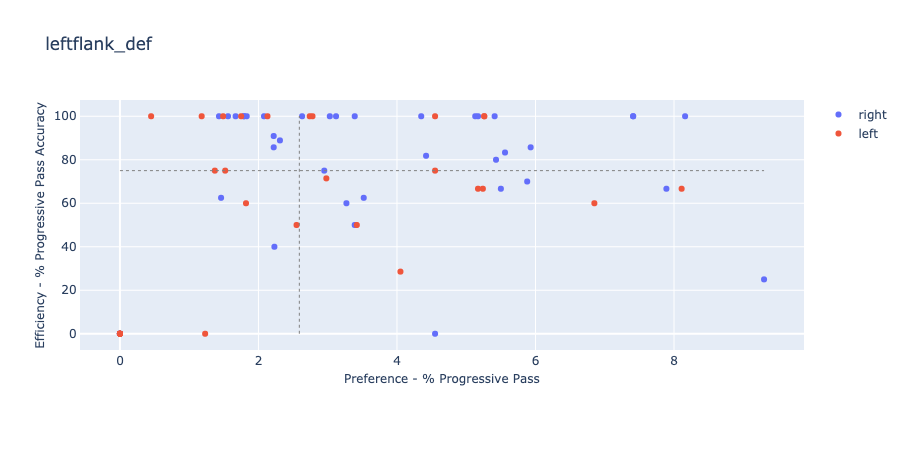

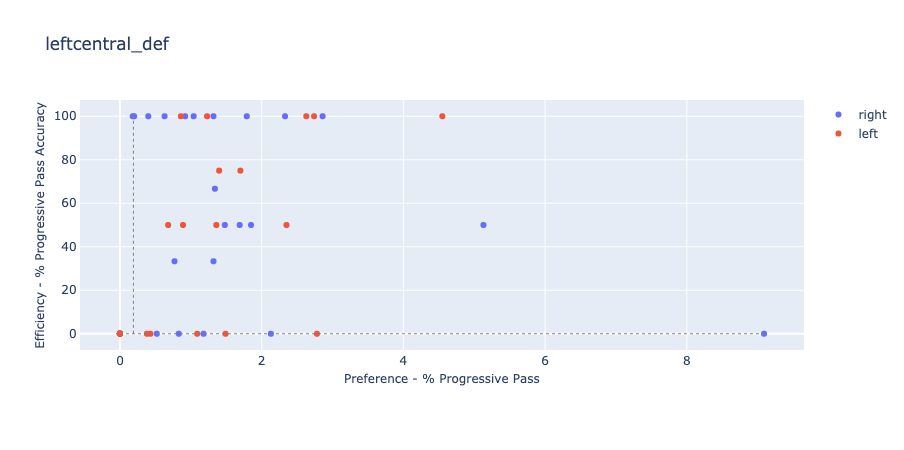

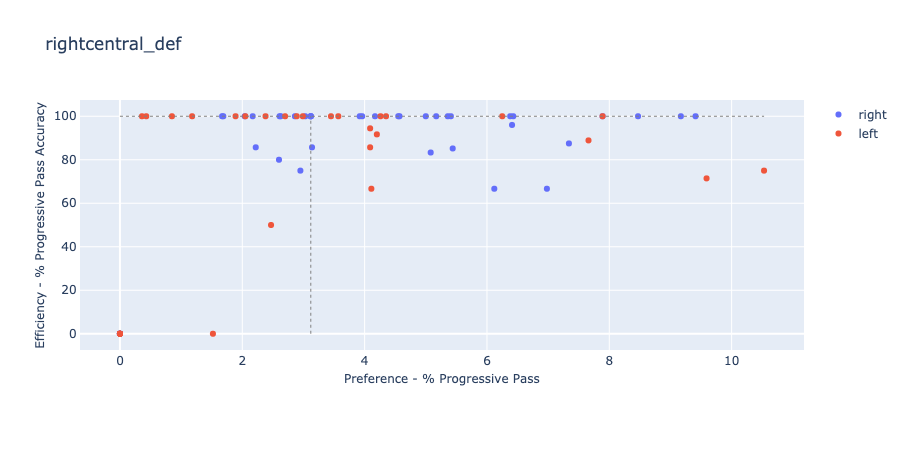

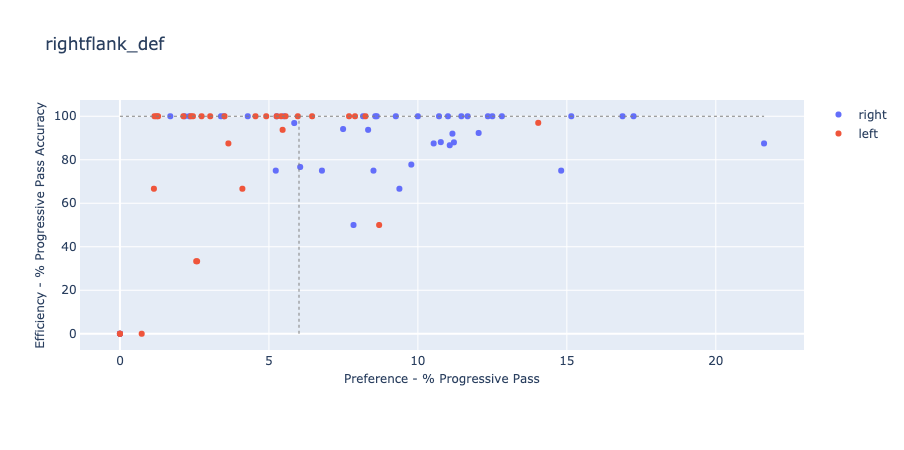

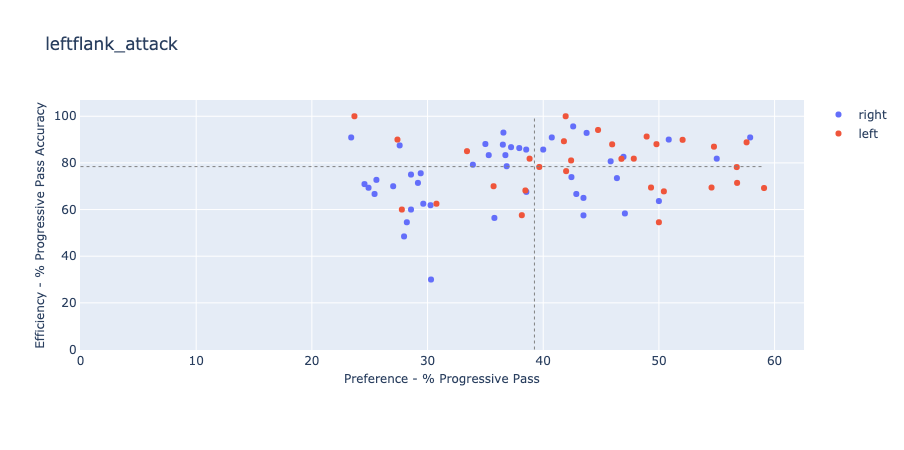

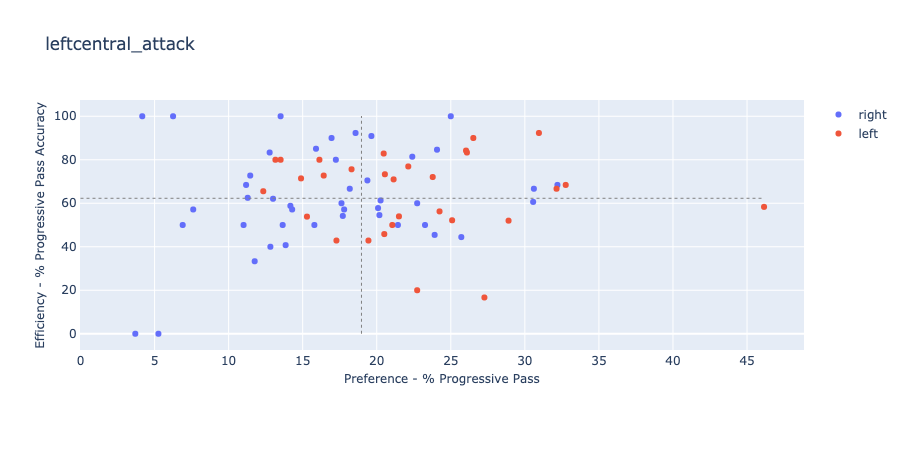

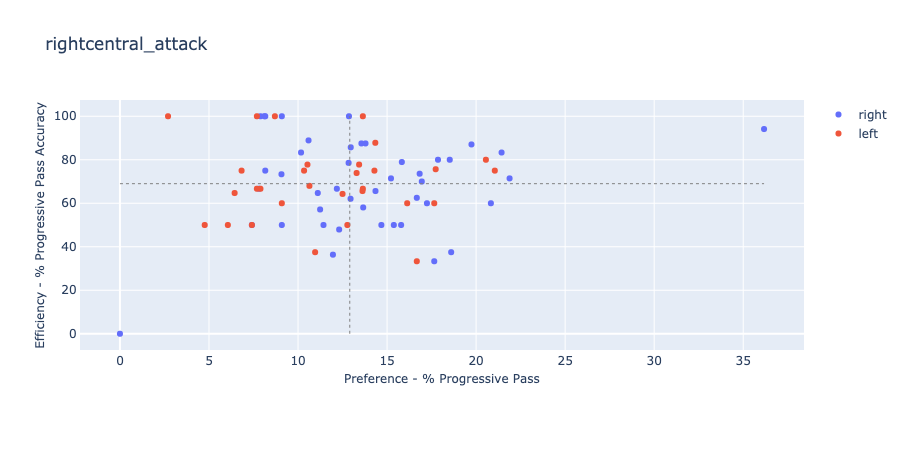

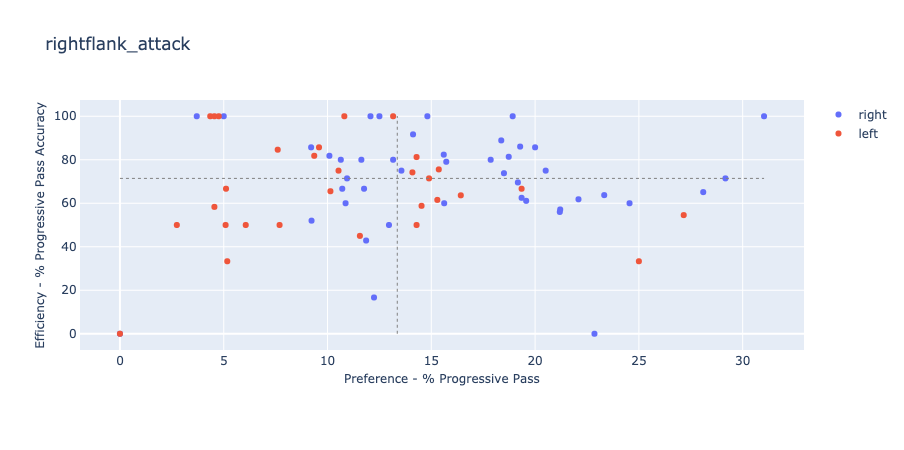

In [210]:
plot_preference_accuracy_region(defender_attrs_lcb_plot_prefacc)

In [154]:
# defender_attrs_lcb.head()

In [155]:
# Saving the region wise pass and vaep-values dataframe
defender_attrs_lcb.to_pickle('../data/defender_clusters/defender_attrs_lcb_region_wise.pkl')

# Generating Offensive Value Added vs Preference Plots For Accurate and Inaccurate Progressive Passes

In [156]:
defender_attrs_lcb = pd.read_pickle('../data/defender_clusters/defender_attrs_lcb_region_wise.pkl')

In [157]:
# Limiting the number of columns in a dataframe for plotting purpose
defender_attrs_lcb_plot = defender_attrs_lcb[[
    'player_name', 'team', 'position', 'footedness', 'matches_played',
    'progaccpass', 'proginaccpass', 'prog_acc_region_per_pass',
    'off_acc_region_per_pass', 'prog_inacc_region_per_pass',
    'off_inacc_region_per_pass'
]]

In [182]:
# Considering only those players who have made more than 20 progressive passes throughout the Season 
defender_attrs_lcb_plot = defender_attrs_lcb_plot.loc[
    defender_attrs_lcb_plot['progaccpass'] +
    defender_attrs_lcb_plot['proginaccpass'] >= 20]

In [183]:
len(defender_attrs_lcb.loc[(defender_attrs_lcb['progaccpass'] + defender_attrs_lcb['proginaccpass']>=20)])

74

In [184]:
player_names = list(zip(defender_attrs_lcb_plot['player_name'].tolist(),defender_attrs_lcb_plot['position'].tolist()))
player_names

[('AaronCresswell', 'LCB'),
 ('AdrianMariappa', 'L_CB'),
 ('AhmedHegazi', 'LCB'),
 ('AhmedHegazi', 'L_CB'),
 ('AlfieMawson', 'LCB'),
 ('AlfieMawson', 'L_CB'),
 ('AngeloOgbonna', 'LCB'),
 ('AngeloOgbonna', 'L_CB'),
 ('AntonioRudiger', 'LCB'),
 ('AshleyWilliams', 'L_CB'),
 ('AymericLaporte', 'L_CB'),
 ('BenMee', 'L_CB'),
 ('BrunoMartinsIndi', 'LCB'),
 ('BrunoMartinsIndi', 'L_CB'),
 ('CalumChambers', 'L_CB'),
 ('ChrisSmalling', 'L_CB'),
 ('ChristianKabasele', 'LCB'),
 ('ChristianKabasele', 'L_CB'),
 ('ChristopherSchindler', 'L_CB'),
 ('CiaranClark', 'LCB'),
 ('CiaranClark', 'L_CB'),
 ('DeclanRice', 'LCB'),
 ('DejanLovren', 'L_CB'),
 ('EliaquimMangala', 'L_CB'),
 ('ErikPieters', 'LCB'),
 ('FlorianLejeune', 'L_CB'),
 ('GaryCahill', 'LCB'),
 ('GeoffCameron', 'LCB'),
 ('HarryMaguire', 'L_CB'),
 ('JamesCollins', 'LCB'),
 ('JamesTarkowski', 'L_CB'),
 ('JamesTomkins', 'L_CB'),
 ('JanVertonghen', 'LCB'),
 ('JanVertonghen', 'L_CB'),
 ('JonnyEvans', 'LCB'),
 ('JonnyEvans', 'L_CB'),
 ('JoseHolebas',

In [215]:
# Function to plot scatter plots for preference over offensive value addition per accurate/inaccurate 
# progresive pass across regions
def plot_preference_value_region(df,result_type):
    regions = [
        'leftflank_def', 'leftcentral_def', 'rightcentral_def',
        'rightflank_def', 'leftflank_attack', 'leftcentral_attack',
        'rightcentral_attack', 'rightflank_attack'
    ]
    foot2color = {'left': 'rgb(60,48,39)', 'right': 'rgb(215,148,39)'}
    foot_colors = df['footedness'].map(foot2color)
    for i in range(8):
        prog_region_right,prog_region_left = list(), list()
        off_region_right,off_region_left = list(), list()
        player_name_right,player_name_left = list(), list()
        player_position_right,player_position_left = list(), list()
        player_foot_right,player_foot_left = list(), list()
        player_team_right,player_team_left = list(), list()
        df_right = df.loc[df['footedness']=='right']
        df_left = df.loc[df['footedness']=='left']
        if result_type == 'Acc':
            for idx, row in df_right.iterrows():
                prog_region_right.append(row['prog_acc_region_per_pass'][i])
                off_region_right.append(np.round(row['off_acc_region_per_pass'][i],2))
                player_name_right.append(row['player_name'])
                player_position_right.append(row['position'])
                player_team_right.append(row['team'])
            for idx, row in df_left.iterrows():
                prog_region_left.append(row['prog_acc_region_per_pass'][i])
                off_region_left.append(np.round(row['off_acc_region_per_pass'][i],2))
                player_name_left.append(row['player_name'])
                player_position_left.append(row['position'])
                player_team_left.append(row['team'])
        elif result_type == 'Inacc':
            for idx, row in df_right.iterrows():
                prog_region_right.append(row['prog_inacc_region_per_pass'][i])
                off_region_right.append(np.round(row['off_inacc_region_per_pass'][i],2))
                player_name_right.append(row['player_name'])
                player_position_right.append(row['position'])
                player_team_right.append(row['team'])
            for idx, row in df_left.iterrows():
                prog_region_left.append(row['prog_inacc_region_per_pass'][i])
                off_region_left.append(np.round(row['off_inacc_region_per_pass'][i],2))
                player_name_left.append(row['player_name'])
                player_position_left.append(row['position'])
                player_team_left.append(row['team'])
        prog_region = prog_region_right + prog_region_left
        off_region = off_region_right + off_region_left
        fig = go.Figure()
        fig.add_trace(
            go.Scatter(x=prog_region_right,
                       y=off_region_right,
                       text = [f'Name: {p_name}<br>Position: {p_pos}<br>Team:{p_team}<br>Coords:{(x,y)}' 
                               for p_name,p_pos,p_team,x,y in zip(player_name_right,player_position_right,
                                                                  player_team_right,prog_region_right,
                                                                  off_region_right)],
                       hoverinfo = 'text',
                       name='right-footed',
                       mode='markers',
                       ))
        fig.add_trace(
            go.Scatter(x=prog_region_left,
                       y=off_region_left,
                       text = [f'Name: {p_name}<br>Position: {p_pos}<br>Team:{p_team}<br>Coords:{(x,y)}' 
                               for p_name,p_pos,p_team,x,y in zip(player_name_left,player_position_left,
                                                                  player_team_left,prog_region_left,
                                                                  off_region_left)],
                       hoverinfo = 'text',
                       name='left-footed',
                       mode='markers'))
        fig.update_layout(shapes=[
            dict(type='line',
                 yref='y',
                 y0=min(off_region),
                 y1=max(off_region),
                 xref='x',
                 x0=statistics.median(prog_region),
                 x1=statistics.median(prog_region),
                 line=dict(color="Grey", width=1, dash="dot")),
            dict(type='line',
                 yref='y',
                 y0=statistics.median(off_region),
                 y1=statistics.median(off_region),
                 xref='x',
                 x0=0,
                 x1=max(prog_region),
                 line=dict(color="Grey", width=1, dash="dot"))
        ])
        fig.update_layout(annotations=[
            dict(x=0.5,
                 y=-0.15,
                 showarrow=False,
                 text='Preference - % Progressive Passes '+ result_type,
                 xref="paper",
                 yref="paper"),
            dict(
                x=-0.1,
                y=0.5,
                showarrow=False,
                text=
                'Offensive Value Added per progressive pass <br>(scaled to 10000)',
                textangle=-90,
                xref="paper",
                yref="paper")
        ],
                          autosize=True,
                          margin=dict(b=100),
                          title_text=str(regions[i]))
        fig.show()
        fig.write_html(f"../data/defender_clusters/offvalue_accinaccpass_plots/{str(regions[i])}_{result_type}.html")

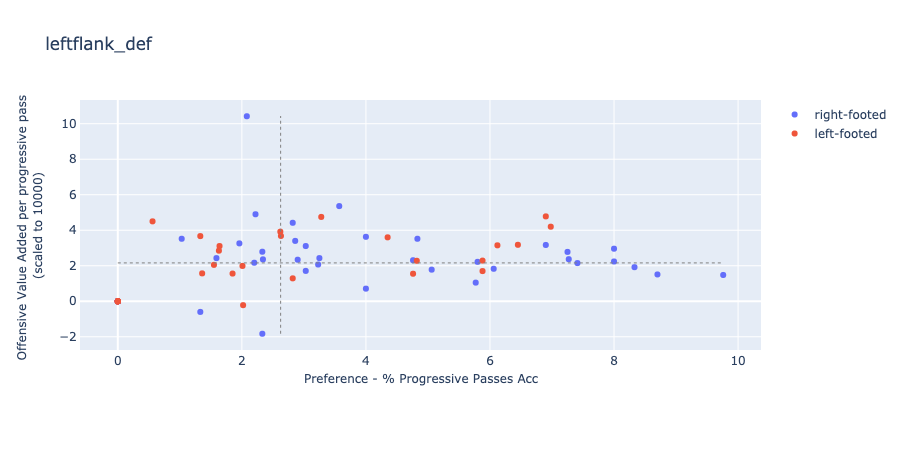

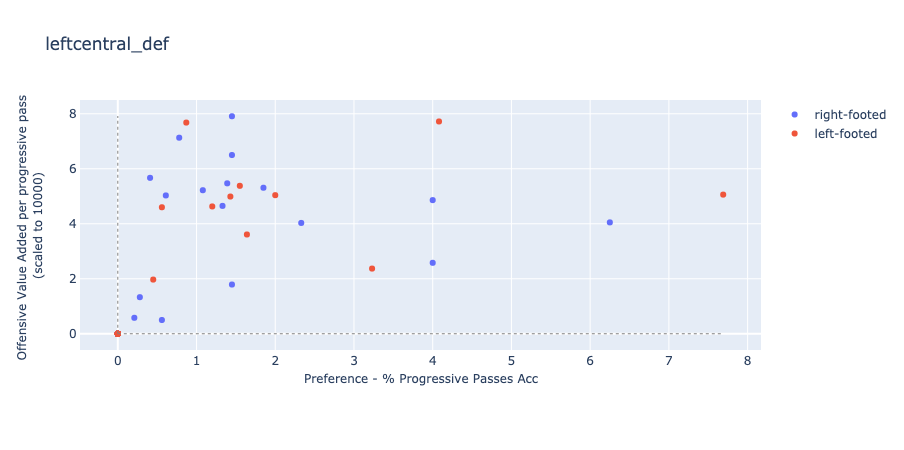

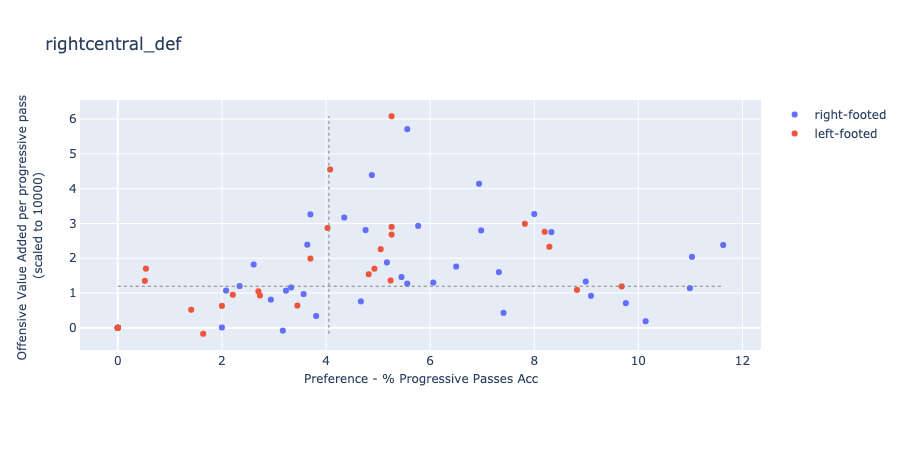

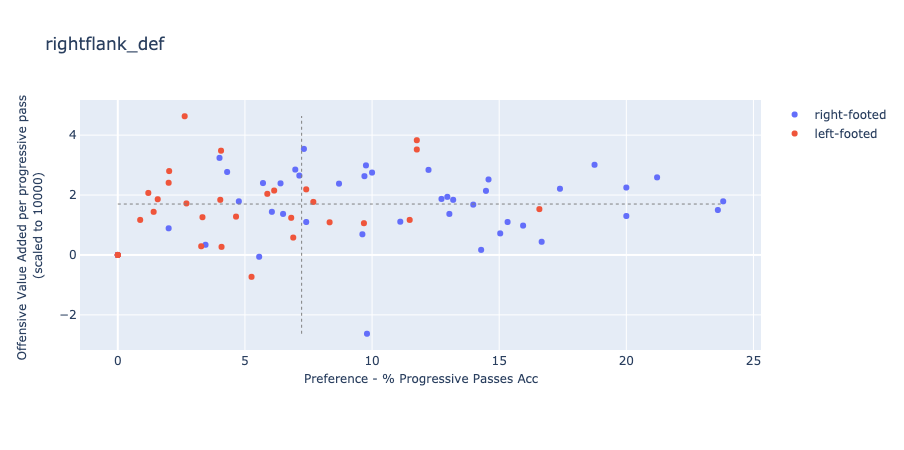

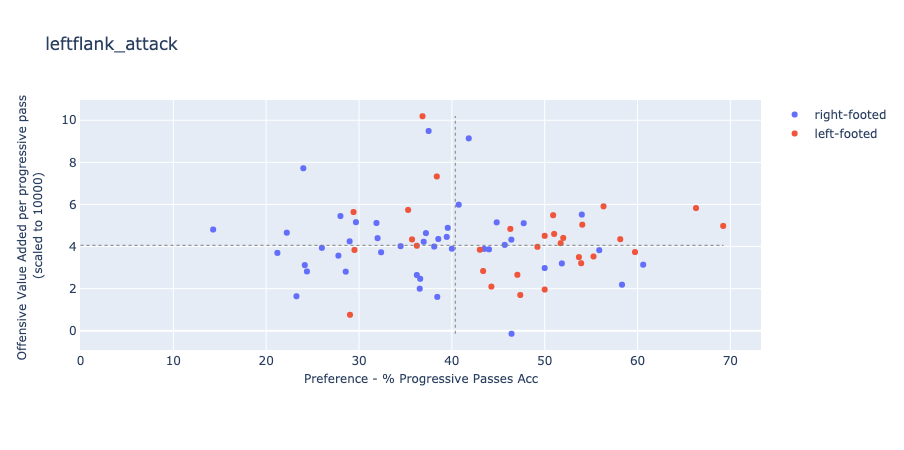

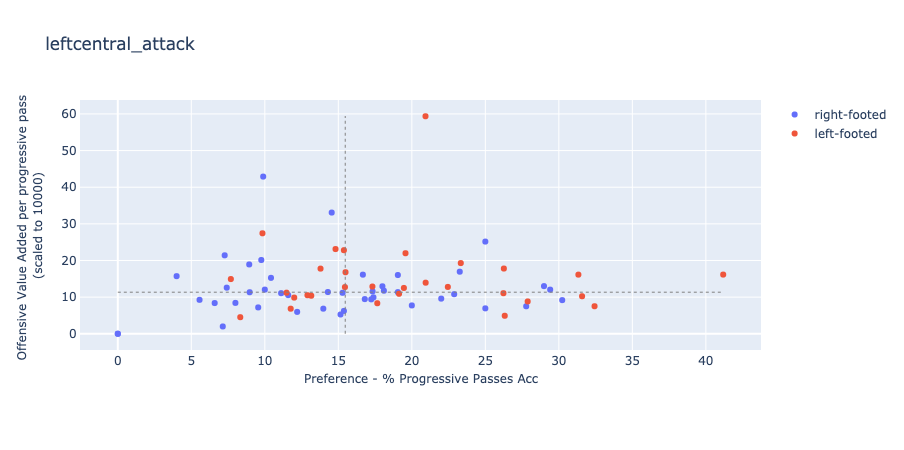

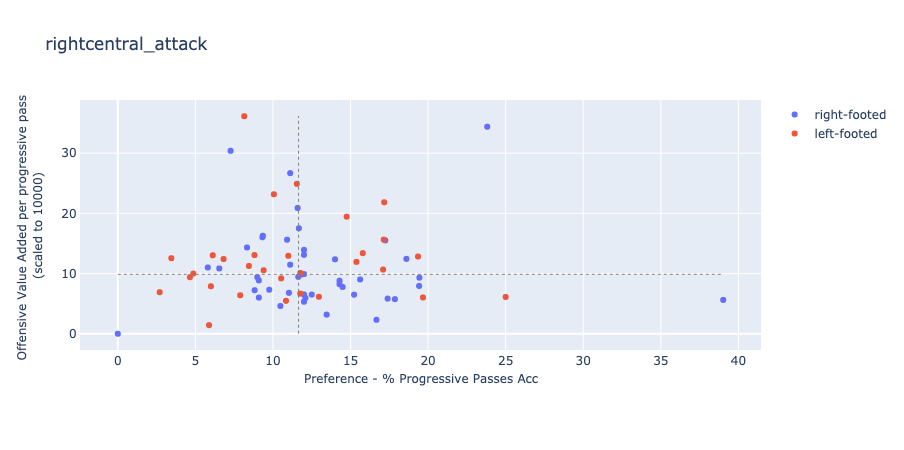

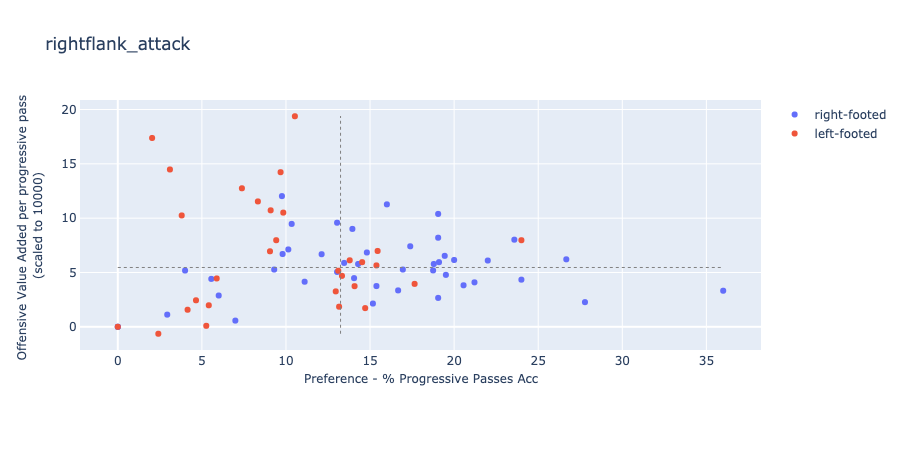

In [216]:
plot_preference_value_region(defender_attrs_lcb_plot, result_type = 'Acc')

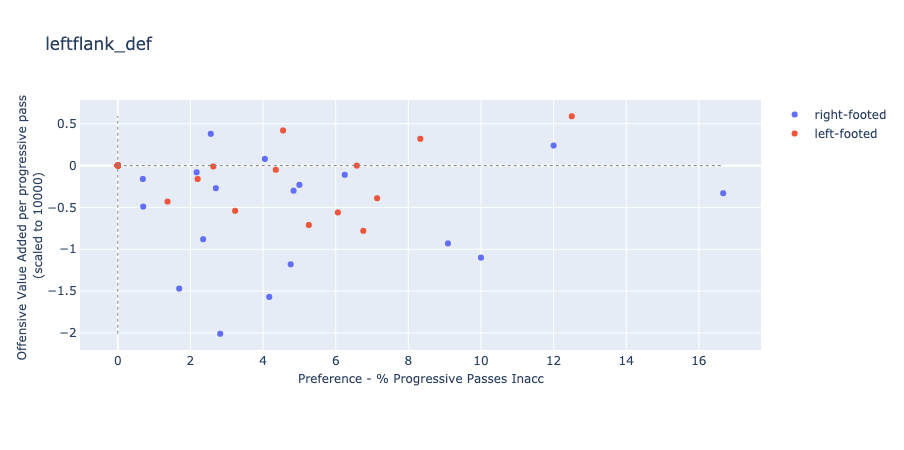

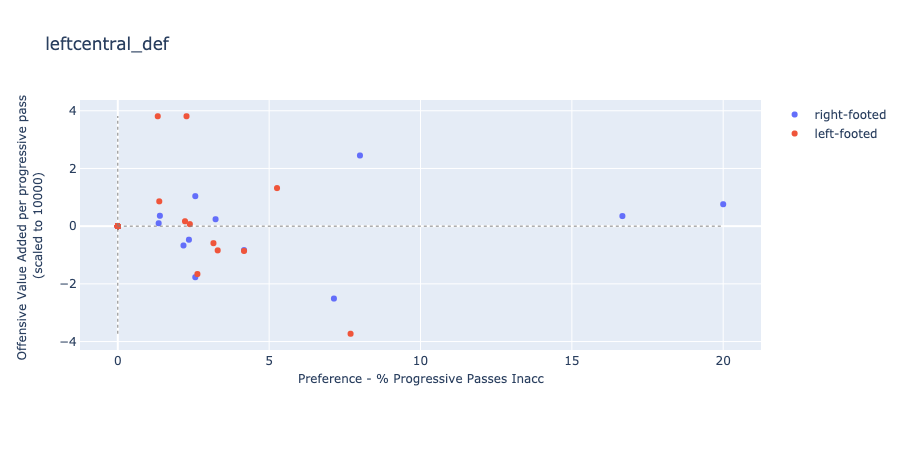

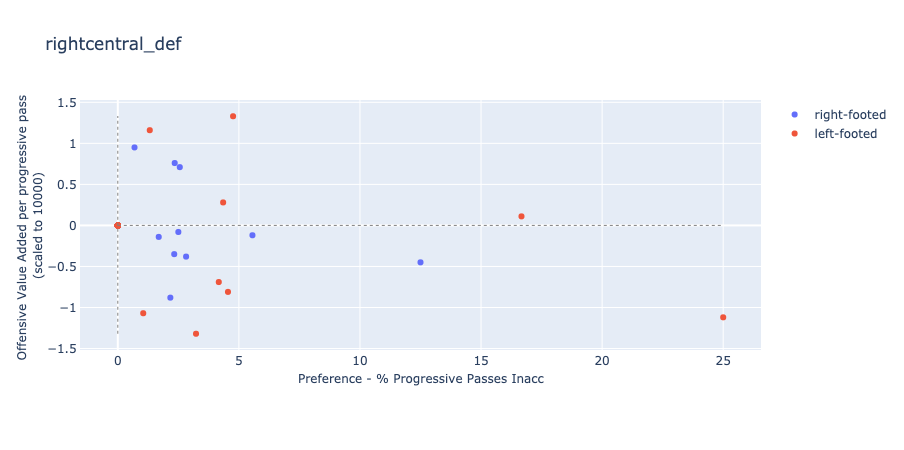

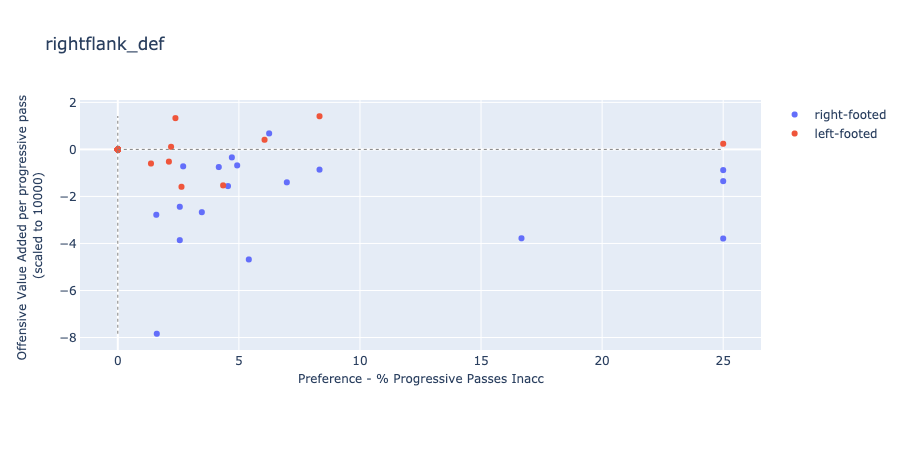

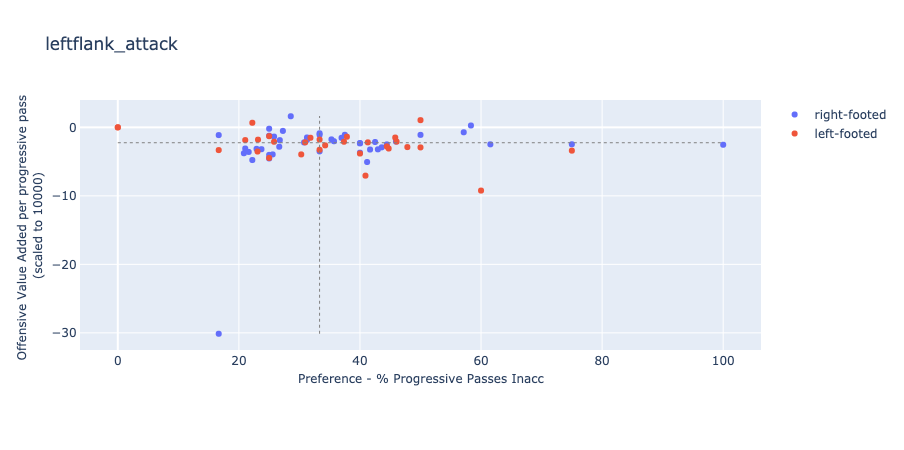

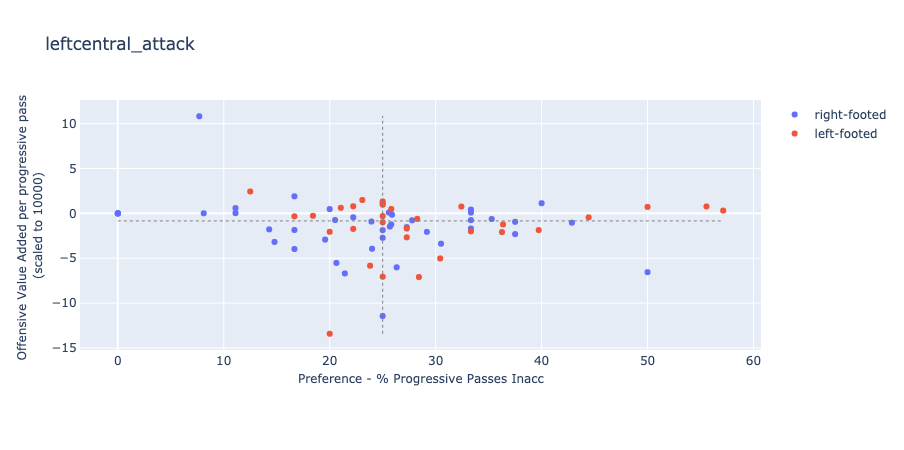

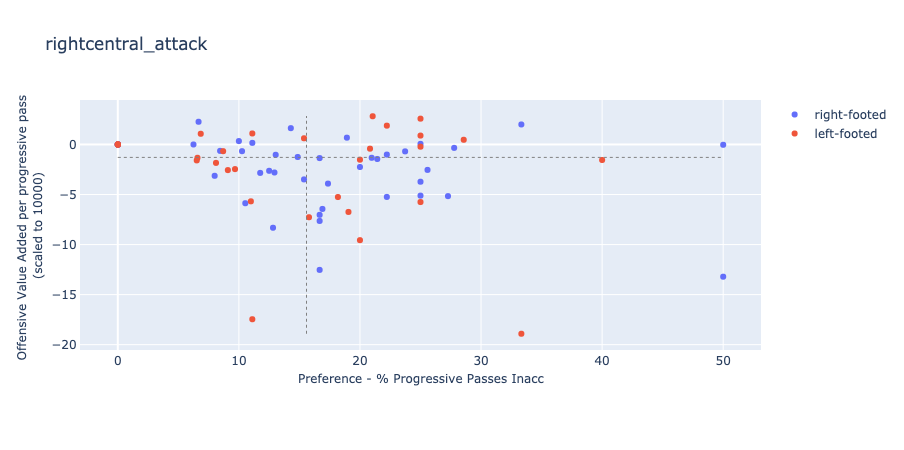

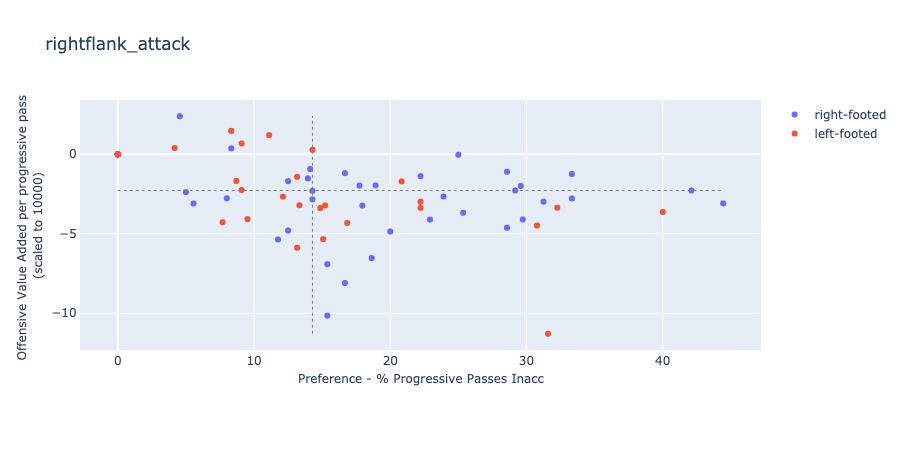

In [217]:
plot_preference_value_region(defender_attrs_lcb_plot, result_type = 'Inacc')

In [164]:
# defender_attrs_lcb.loc[defender_attrs_lcb['player_name'].str.contains('Jan')]

## Generating Cumulative Offensive Values Added vs Preference Plots For Progressive Passes


In [174]:
# Function to calculate total offensive value added per progressive pass in each region.
# It takes into account both accurate and inaccurate progressive passes
def off_cumulative_preference(progacclocs,proginacclocs, off_acc, off_inacc):
    progacclocs_start, progacclocs_end = getstartend(progacclocs)
    prog_acclocs_x, prog_acclocs_y = getxy(progacclocs_end)
    off_acc_region = get_vaep_region(prog_acclocs_x,prog_acclocs_y,off_acc)
    proginacclocs_start,proginacclocs_end = getstartend(proginacclocs)
    prog_inacclocs_x, prog_inacclocs_y = getxy(proginacclocs_end)
    off_inacc_region = get_vaep_region(prog_inacclocs_x,prog_inacclocs_y,off_inacc)
    prog_acc_region = get_pass_region(prog_acclocs_x,prog_acclocs_y)
    prog_inacc_region = get_pass_region(prog_inacclocs_x,prog_inacclocs_y)
    total_off_region = [off_acc_region[i] + off_inacc_region[i] for i in range(8)]
    total_prog_region = [prog_acc_region[i] + prog_inacc_region[i] for i in range(8)]
    total_off_region_per_pass = list()
    for i in range(8):
        if total_prog_region[i]!=0:
            total_off_region_per_pass.append((total_off_region[i]/total_prog_region[i])*1000)
        else:
            total_off_region_per_pass.append(0)
    return pd.Series([total_off_region_per_pass])

In [175]:
defender_attrs_lcb['total_off_region_per_pass'] = defender_attrs_lcb.apply(lambda x : off_cumulative_preference(x['progaccpassloc'],x['proginaccpassloc'],x['progaccpassoff'],x['proginaccpassoff']),axis=1)

In [202]:
# defender_attrs_lcb.head()

In [188]:
# Limiting the data by taking into account players who have made atleast 20 progressive passes
defender_attrs_lcb_plot = defender_attrs_lcb.loc[defender_attrs_lcb['progaccpass'] + defender_attrs_lcb['proginaccpass'] >= 20]

In [218]:
# Function to plot preference for progressive passes vs offensive value added per progressive pass in each region
def plot_cumulativeoff_preference(df):
    regions = [
        'leftflank_def', 'leftcentral_def', 'rightcentral_def',
        'rightflank_def', 'leftflank_attack', 'leftcentral_attack',
        'rightcentral_attack', 'rightflank_attack'
    ]
    foot2color = {'left': 'rgb(60,48,39)', 'right': 'rgb(215,148,39)'}
    foot_colors = df['footedness'].map(foot2color)
    
    for i in range(8):
        prog_region_right,prog_region_left = list(), list()
        off_region_right,off_region_left = list(), list()
        player_name_right,player_name_left = list(), list()
        player_position_right,player_position_left = list(), list()
        player_foot_right,player_foot_left = list(), list()
        player_team_right,player_team_left = list(), list()
        df_right = df.loc[df['footedness']=='right']
        df_left = df.loc[df['footedness']=='left']
        for idx, row in df_right.iterrows():
            prog_region_right.append(row['progpreference_per_region'][i])
            off_region_right.append(row['total_off_region_per_pass'][i])
            player_name_right.append(row['player_name'])
            player_position_right.append(row['position'])
            player_team_right.append(row['team'])
        for idx, row in df_left.iterrows():
            prog_region_left.append(row['progpreference_per_region'][i])
            off_region_left.append(row['total_off_region_per_pass'][i])
            player_name_left.append(row['player_name'])
            player_position_left.append(row['position'])
            player_team_left.append(row['team'])
        prog_region = prog_region_right + prog_region_left
        off_region = off_region_right + off_region_left
        fig = go.Figure()
        fig.add_trace(
            go.Scatter(x=prog_region_right,
                       y=off_region_right,
                       text = [f'Name: {p_name}<br>Position: {p_pos}<br>Team:{p_team}<br>Coords:{(x,y)}' 
                               for p_name,p_pos,p_team,x,y in zip(player_name_right,player_position_right,
                                                                  player_team_right,prog_region_right,
                                                                  off_region_right)],
                       hoverinfo = 'text',
                       name='right-footed',
                       mode='markers'))
        fig.add_trace(
            go.Scatter(x=prog_region_left,
                       y=off_region_left,
                       text = [f'Name: {p_name}<br>Position: {p_pos}<br>Team:{p_team}<br>Coords:{(x,y)}' 
                               for p_name,p_pos,p_team,x,y in zip(player_name_left,player_position_left,
                                                                  player_team_left,prog_region_left,
                                                                  off_region_left)],
                       hoverinfo = 'text',
                       name='left-footed',
                       mode='markers'))
        fig.update_layout(shapes=[
            dict(type='line',
                 yref='y',
                 y0=min(off_region),
                 y1=max(off_region),
                 xref='x',
                 x0=statistics.median(prog_region),
                 x1=statistics.median(prog_region),
                 line=dict(color="Grey", width=1, dash="dot")),
            dict(type='line',
                 yref='y',
                 y0=statistics.median(off_region),
                 y1=statistics.median(off_region),
                 xref='x',
                 x0=0,
                 x1=max(prog_region),
                 line=dict(color="Grey", width=1, dash="dot"))
        ])
        fig.update_layout(annotations=[
            dict(x=0.5,
                 y=-0.15,
                 showarrow=False,
                 text='Preference - % Progressive Pass',
                 xref="paper",
                 yref="paper"),
            dict(x=-0.1,
                 y=0.5,
                 showarrow=False,
                 text='Offensive value added per progressive pass<br>(scaled by 1000)',
                 textangle=-90,
                 xref="paper",
                 yref="paper")
        ])
        fig.update_layout(autosize=True,
                          margin=dict(b=100),
                          title_text=str(regions[i]),
                          showlegend = True)
        fig.show()
        fig.write_html(f"../data/defender_clusters/offvalue_preference_plots/{str(regions[i])}.html")

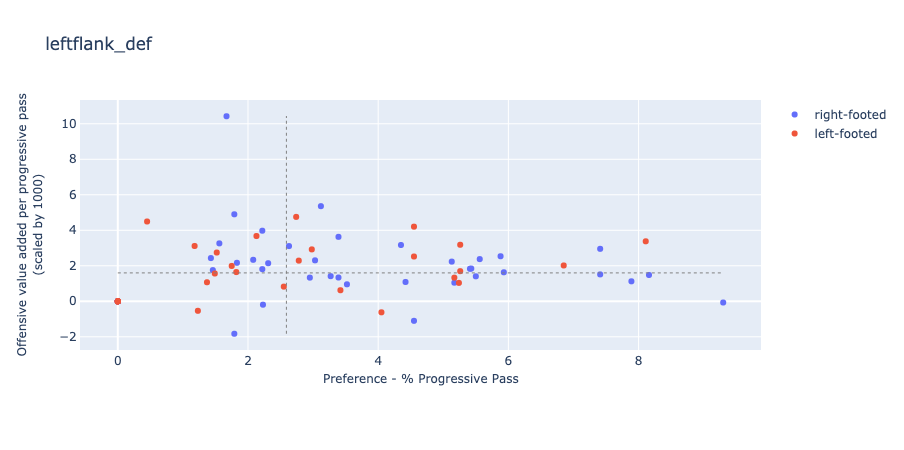

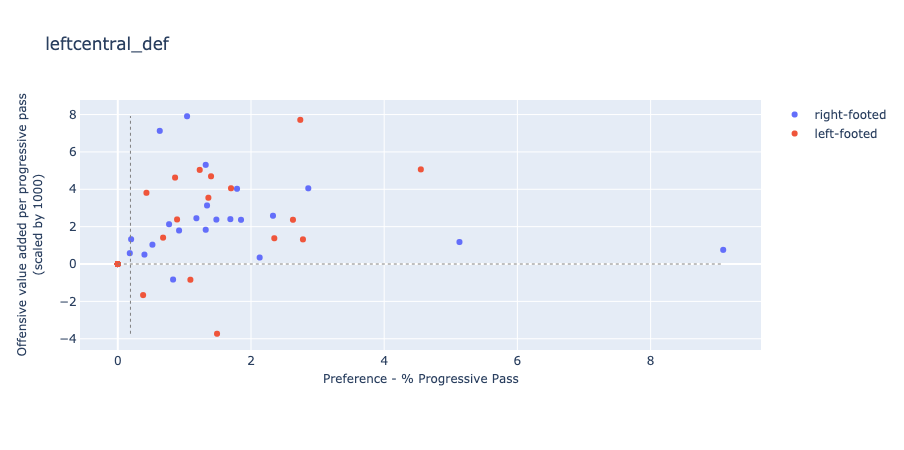

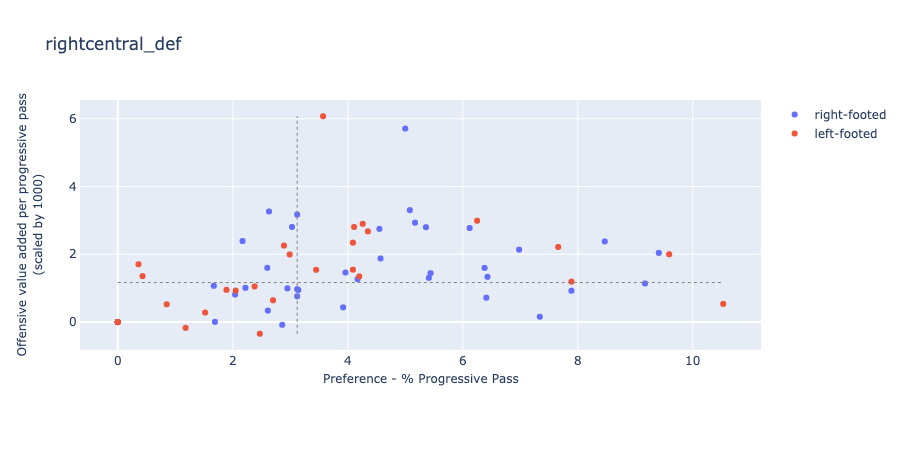

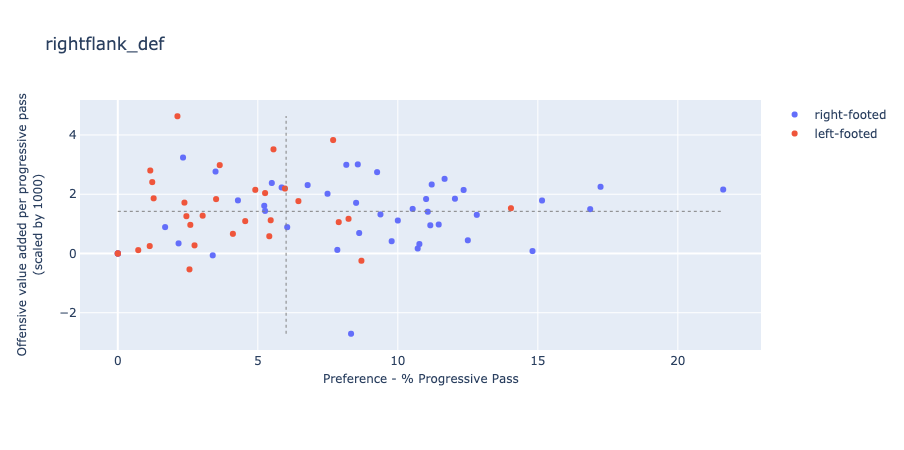

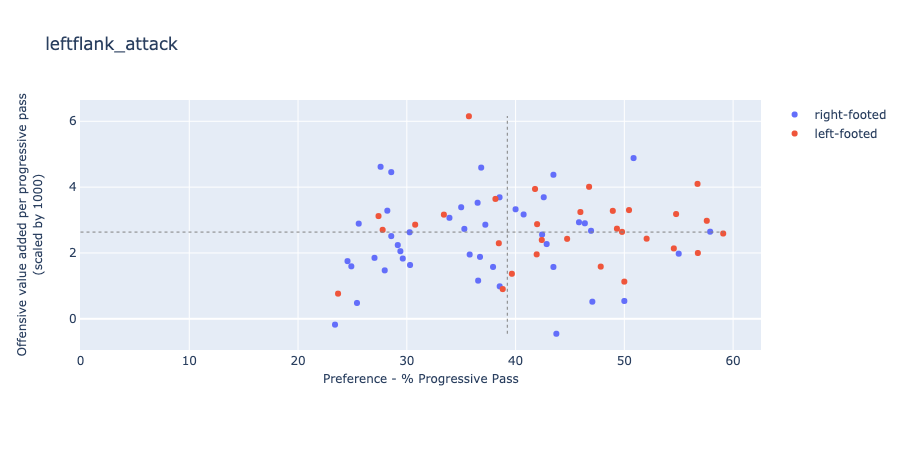

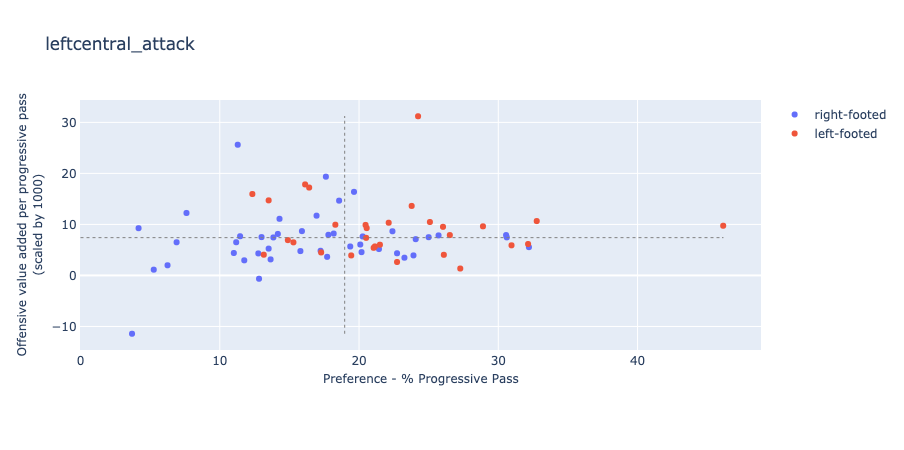

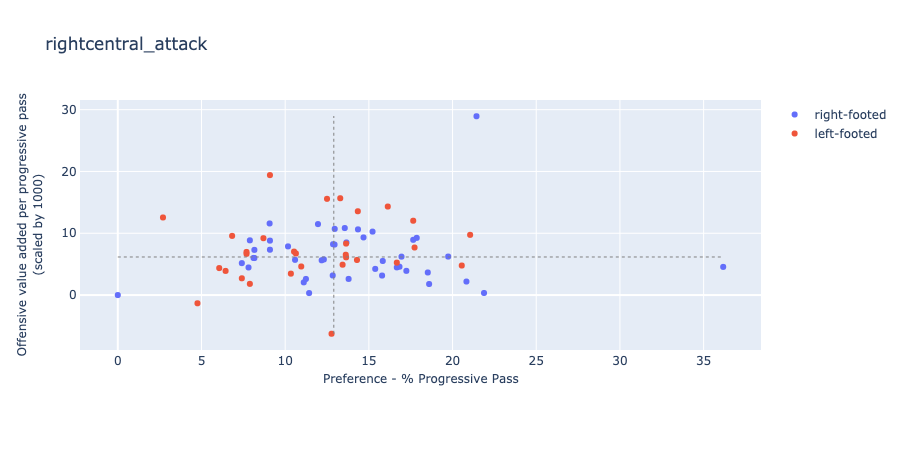

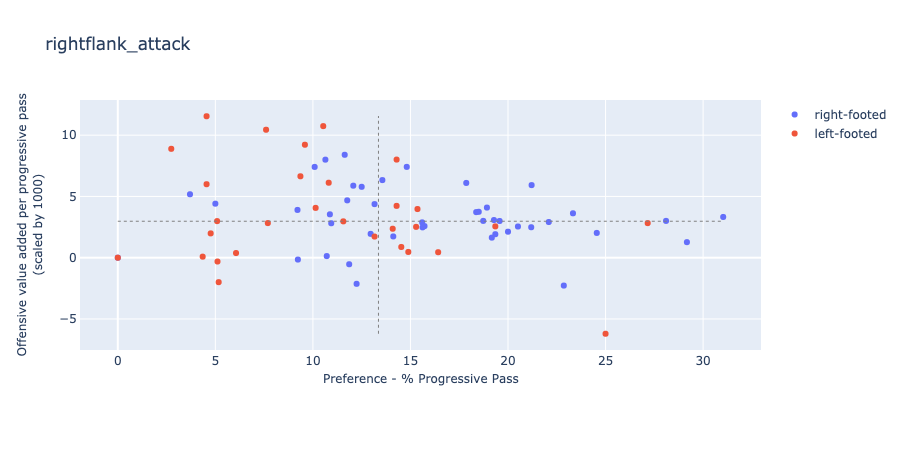

In [219]:
plot_cumulativeoff_preference(defender_attrs_lcb_plot)

In [221]:
# Saving dataframe in data folder
defender_attrs_lcb.to_pickle('../data/defender_clusters/defender_attrs_lcb_region_wise.pkl')

# Appendix

## Column Name Meanings for `defender_attrs_lcb` 

1. `player_name`: Player Name
2. `team`: Team the Player played for
3. `position`: Position of the Player in the defensive line-up - <br>
    `LCB`: Left Center Back in 4 ATB formation<br>
    `L_CB`: Left Center Back in 3/5 ATB formation<br> 
4. `footedness`: Dominant foot of the player<br>
5. `matches_played`: Total Matches Played by the player for the respective `team` + `position` <br>
6. `passes`: Total Passes made by the player in these `matches_played`<br>
7. `accpass`: Total Accurate Passes made by the player in these `matches_played`<br>
8. `progaccpass`: Total Accurate Progressive Passes made by the player in these `matches_played`<br>
9. `proginaccpass`: Total Inaccurate Progressive Passes made by the player in these `matches_played`<br>
10. `accpassloc`: End Point Locations of all the Accurate Passes made by the player in these `matches_played`<br>
11. `inaccpassloc`: End Point Locations of all the Inaccurate Passes made by the player in these `matches_played`<br>
12. `progaccpassloc`: End Point Locations of all the Accurate Progressive Passes made by the player in these `matches_played`<br>
13. `proginaccpassloc`: End Point Locations of all the Inaccurate Progressive Passes made by the player in these `matches_played`<br>
14. `accpassvaep`: `VAEP` Value of all the Accurate Passes made by the player in these `matches_played`<br>
15. `inaccpassvaep`: `VAEP` Value of all the Inaccurate Passes made by the player in these `matches_played`<br>
16. `progaccpassvaep`: `VAEP` Value of all the Accurate Progressive Passes made by the player in these `matches_played`<br>
17. `proginaccpassvaep`: `VAEP` Value of all the Inaccurate Progressive Passes made by the player in these `matches_played`<br>
18. `accpassoff`: `Offensive - VAEP Coefficient` Value of all the Accurate Passes made by the player in these `matches_played`<br>
19. `inaccpassoff`: `Offensive - VAEP Coefficient` Value of all the Inaccurate Passes made by the player in these `matches_played`<br>
20. `progaccpassoff`: `Offensive - VAEP Coefficient` Value of all the Accurate Progressive Passes made by the player in these `matches_played`<br>
21. `proginaccpassoff`: `Offensive - VAEP Coefficient` Value of all the Inaccurate Progressive Passes made by the player in these `matches_played`<br>
22. `accpassdef`: `Defensive - VAEP Coefficient` Value of all the Accurate Passes made by the player in these `matches_played`<br>
23. `inaccpassdef`: `Defensive - VAEP Coefficient` Value of all the Inaccurate Passes made by the player in these `matches_played`<br>
24. `progaccpassdef`: `Defensive - VAEP Coefficient` Value of all the Accurate Progressive Passes made by the player in these `matches_played`<br>
25. `proginaccpassdef`: `Defensive - VAEP Coefficient` Value of all the Inaccurate Progressive Passes made by the player in these `matches_played`<br>
26. `prog_acc_region_per_pass`: Ratio of (Total Accurate Progressive Passes in each of the 8 regions of the field), to the (Total Accurate Passes) made by the Player cumulated for these `matches_played` <br> 
27. `vaep_acc_region_per_pass`: Ratio of (`VAEP` Value added by the Total Accurate Progressive Passes in each of the 8 regions of the field), to the (Total Accurate Passes) made by the Player cumulated for these `matches_played` <br> 
28. `prog_inacc_region_per_pass`: Ratio of (Total Inaccurate Progressive Passes in each of the 8 regions of the field), to the (Total Inaccurate Passes) made by the Player cumulated for these `matches_played` <br> 
29. `vaep_inacc_region_per_pass`: Ratio of (`VAEP` Value added by the Total Inaccurate Progressive Passes in each of the 8 regions of the field), to the (Total Inaccurate Passes) made by the Player cumulated for these `matches_played` <br> 
30. `off_acc_region_per_pass`: Ratio of (`Offensive - VAEP Coefficient` Value added by the Total Accurate Progressive Passes in each of the 8 regions of the field), to the (Total Accurate Passes) made by the Player cumulated for these `matches_played` <br> 
31. `off_inacc_region_per_pass`: Ratio of (`Offensive - VAEP Coefficient` Value added by the Total Inaccurate Progressive Passes in each of the 8 regions of the field), to the (Total Inaccurate Passes) made by the Player cumulated for these `matches_played` <br> 
32. `def_acc_region_per_pass`: Ratio of (`Defensive - VAEP Coefficient` Value added by the Total Accurate Progressive Passes in each of the 8 regions of the field), to the (Total Accurate Passes) made by the Player cumulated for these `matches_played` <br> 
33. `def_inacc_region_per_pass`: Ratio of (`Defensive - VAEP Coefficient` Value added by the Total Inaccurate Progressive Passes in each of the 8 regions of the field), to the (Total Inaccurate Passes) made by the Player cumulated for these `matches_played` <br> 
34. `progpreference_per_region`: Ratio of (Total Progressive Passes in each of the 8 regions of the Field), to the (Total Progressive Passes) made by the Player cumulated for these `matches_played`. Indicates `Preference` of the Player to pass in each of the Regions. <br>
35. `progaccurary_per_region`: Ratio of (Total Accurate Progressive Passes in each of the 8 regions of the Field), to the (Total Progressive Passes in each of the 8 regions of the field) made by the Player cumulated for these `matches_played`. Indicates the Accuracy of the Player in each of the Regions. <br>
36. `total_off_region_per_region` : Ratio of (Total `Offensive - VAEP Coefficient` Value added by Total Progressive Passes in each of the 8 regions of the field), to the (Total Progressive Passes) made by the Player cumulated for these `matches_played`